# Sprawozdanie z laboratorium - sieci neuronowe

Temat:  Rozpoznawanie dźwięków ptaków.

Skład grupy:

    Marcin Kajzer
    Marcin Dończyk

# Opis zadania

Określić czy na podanym fragmencie nagrania można usłyszeć śpiew ptaka czy nie.

Model po wprowadzeniu przykładowego fragmentu nagrania ma rozstrzygnąć powyższy problem zwracając odpowiedź oraz prawdopodobieństwo z jakim odpowiedź jest prawidłowa.


# Dane i analiza

Dane użyte w projekcie są zbiorem 4000 nagrań, z czego każde ma równo 10s. 

Do zbioru dołączony był plik w formacie csv, zawierajcy nazwę nagrania w kolumnie "itemid" oraz w kolumnie "hasbird" odpowiednio 1, gdy na nagraniu jest śpiew ptaka i 0, gdy nie ma.

Zbiór został podzielony na dane treningowe w ilości 3200 oraz testowe w ilości 800 fragmentów.
Z kolei każdy z podzbiorów zawiera po połowe fragmentów ze śpiewem ptaka oraz bez śpiewu (podzielone za pomocą odpowiedniej funkcji, wykorzystującej wyżej wspomniany plik csv) 

Aby móc nauczyć nasz model klasyfikacji dźwięków w pierwszej kolejności przekształciliśmy zbiór dźwięków w formacie wav na zbiór spektrogramów zapisanych w formacie jpg.

Spektrogram jest wykresem dźwięku, który zawiera zarówno amplitudę, częstotliwość jak i czas - taka ilość parametrów pozwala na odróżnienie poszczególnych nagrań.

Wszystkie nagrania były już odpowiedniej długości, więc wystarczyło zastosować odpowiedznią funkcję.

Dla przykładu ten dźwięk:

In [3]:
from IPython.display import Audio
Audio("000a3cad-ef99-4e5e-9845.wav")

Po przekształceniu w spektrogram wygląda tak: 

(0.004353741496598639, 10.235646258503403, 0.0, 22050.0)

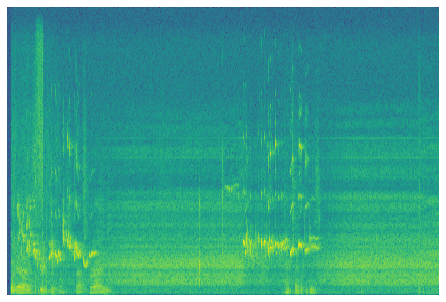

In [7]:
import matplotlib.pyplot as plt
from scipy.io import wavfile


rate, data = wavfile.read("000a3cad-ef99-4e5e-9845.wav")

fig,ax = plt.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.axis('off')
pxx, freqs, bins, im = ax.specgram(x=data, Fs=rate, noverlap=384, NFFT=512)
ax.axis('off')

# Żródło danych

Dane zostały zaczerpnięte ze strony:

http://dcase.community/challenge2018/task-bird-audio-detection?fbclid=IwAR0xWE9BlnUN2dVMcFbbM-fRHtS_fkcwScaKY74szMZaCDgft40e7Ea6GOE#audio-datasets

Zbiór danych, z którego skorzystaliśmy to "warblrb10k".

# Model

Do stworzenia naszego modelu skorzystaliśmy z biblioteki Keras.

1) Rodzaj sieci neuronowej
    
    Ze względu na dane graficzne użyliśmy sieci konwolucyjnej.
    
2) Opis architektury

    Sieć składa się z 3 warstw konwolucyjnych z funkcjami aktywacji "ReLu", oraz dwóch warstw gęstych. Ostateczna funkcja 
    aktywacji to funckja sigmoidalna.
      


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

img_width, img_height = 320, 240

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Działanie

Aby uruchomić model należy odpowiednio wczytać zbiór naszych spektrogramów (skorzytaliśmy z ImageDataGenerator z bliblioteki Keras), a następnie wywołać funkcję "fit_generator" z odpowiednimi parametrami dla stworzonego modelu.

In [15]:
from keras.preprocessing.image import ImageDataGenerator, image

train_data_dir = r'C:\Users\kajze\Desktop\sieci\training'
validation_data_dir = r'C:\Users\kajze\Desktop\sieci\test'
nb_train_samples = 3200
nb_validation_samples = 800
epochs = 5
batch_size = 16

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


datagen = ImageDataGenerator(rescale=1./255)


train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/5
200/200 [==============================] - 223s 1s/step - loss: 0.5707 - acc: 0.7212 - val_loss: 0.5073 - val_acc: 0.7175
Epoch 2/5
200/200 [==============================] - 212s 1s/step - loss: 0.4948 - acc: 0.7663 - val_loss: 0.4673 - val_acc: 0.7638
Epoch 3/5
200/200 [==============================] - 218s 1s/step - loss: 0.4766 - acc: 0.7769 - val_loss: 0.4267 - val_acc: 0.7913
Epoch 4/5
200/200 [==============================] - 188s 938ms/step - loss: 0.4537 - acc: 0.7863 - val_loss: 0.4847 - val_acc: 0.7550
Epoch 5/5
200/200 [==============================] - 144s 718ms/step - loss: 0.4230 - acc: 0.8069 - val_loss: 0.4205 - val_acc: 0.8237


Testy:

Przy pięciu epokach dokładność wychodni na poziomie 80%. 

Przy próbach dla większej liczby epok model się przeuczał.

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 318, 238, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 318, 238, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 159, 119, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 157, 117, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 157, 117, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 78, 58, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 76, 56, 64)        18496     
__________

# Podsumowanie

Przy zbiorze 4000 fragmentów, dzięki modelowi udało się zautomatyzować proces rozpoznawania śpiewu ptaka na fragmencie nagrania z dokładnością na poziomie 80%.

Być może większy zbiór danych pozwoliłby na dokładniejszy wynik.

Najtrudniejszą częścią modelu było znalezienie pomysłu na wczytanie danych - my skorzystaliśmy z ImageDataGenerator z bliblioteki Keras, który na podstawie odpowiedniej struktury plików sam rozpoznaje, z iloma klasami danych ma do czynienia i klasyfikuje je automatycznie na podstawie nazw katalogów.

Dla uzystania większej precyzji możnaby spróbować wytrenować model na większym zbiorze danych.

